In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Imports all required libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
from collections import Counter
import torch.nn.functional as F
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# **3.1 Data Preparation and Exploration**

## **Loading dataset from google collaboratory**

In [ ]:
data_dir = "/content/drive/MyDrive/dataset"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

## **Custom classes for my data**

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None):
        self.image_dir = image_dir
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform

        # Map class labels
        self.label_map = {'cat': 0, 'dog': 1, 'bird': 2}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.label_map[self.annotations.iloc[idx, 1]]

        if self.transform:
            image = self.transform(image)

        return image, label

# **Data Loading and Pre-processing Pipeline**

## -> Normalize pixel values

## -> Augmentations like rotation, flipping, and color jitter for robustness


For training images are resized to 64x64 pixels, randomly flipped, rotated by up to 10° and adjusted for brightness and contrast*to enhance generalization. Both training and testing datasets are converted to PyTorch tensors and normalized with a mean and standard deviation of 0.5 to standardize pixel values.

In [ ]:
train_dir = "/content/drive/MyDrive/dataset/train"
train_csv = "/content/drive/MyDrive/dataset/train.csv"
test_dir = "/content/drive/MyDrive/dataset/test"

# Data Transforms
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Loading datasets and SPlitting
train_dataset = CustomImageDataset(image_dir=train_dir, csv_file=train_csv, transform=train_transform)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=2)

## **Counting number of images in Training, Validatea nd test data**

In [ ]:
train_total = len(pd.read_csv(train_csv))  # Total train images
train_split = int(0.8 * train_total)  # Training set after split (80%)
val_split = train_total - train_split  # Validation set after split (20%)
test_total = len(os.listdir(test_dir))  # Total test images

# Print the counts
print(f"Total Images in Training Dataset: {train_split}")
print(f"Total Images in Validation Dataset: {val_split}")
print(f"Total Images in Test Dataset: {test_total}")

Total Images in Training Dataset: 9600
Total Images in Validation Dataset: 2400
Total Images in Test Dataset: 3000


## **Validating number of images in train,validation and testing**

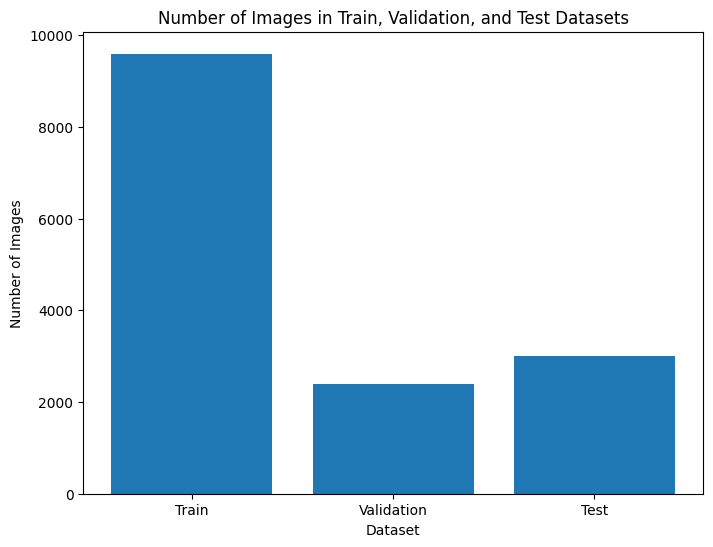

In [ ]:
dataset_counts = {
    "Train": train_split,
    "Validation": val_split,
    "Test": test_total
}

# Plot
plt.figure(figsize=(8, 6))
plt.bar(dataset_counts.keys(), dataset_counts.values())
plt.title('Number of Images in Train, Validation, and Test Datasets')
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.show()

## **Custom labels for Test Data**

In [ ]:
class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, self.image_files[idx]

test_dataset = TestDataset(image_dir=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

### **Checking total traiining images**

In [ ]:
train_df = pd.read_csv(train_csv)
print("Train Dataset Info:")
print(train_df.head())
print(f"Total Training Images: {len(train_df)}")
print(f"Unique Labels: {train_df['label'].unique()}")

Train Dataset Info:
       filename label
0  cat_1516.png   cat
1  dog_8219.png   dog
2  cat_9086.png   cat
3  cat_4941.png   cat
4  bird_217.png  bird
Total Training Images: 12000
Unique Labels: ['cat' 'dog' 'bird']


## **Balanced Dataset**

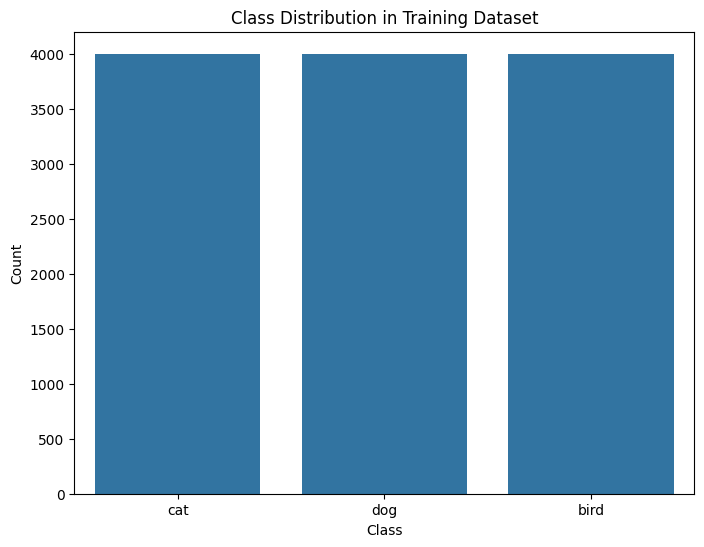

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train_df, x='label')
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### **Image Dimension checked**

In [ ]:
sample_images = train_df['filename'].sample(5)
for img_name in sample_images:
    img_path = os.path.join(train_dir, img_name)
    with Image.open(img_path) as img:
        print(f"{img_name}: {img.size}")

bird_10071.png: (32, 32)
cat_6719.png: (32, 32)
cat_5118.png: (32, 32)
bird_5296.png: (32, 32)
bird_4514.png: (32, 32)


## **Visualize the dimension of Images**

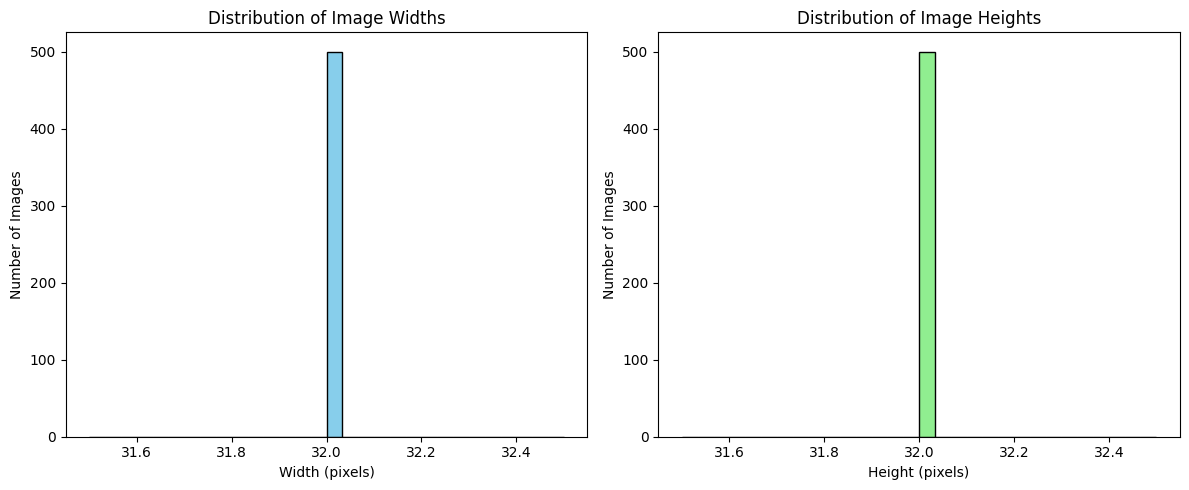

In [ ]:
image_dimensions = []
for img_name in train_df['filename'].sample(500):
    img_path = os.path.join(train_dir, img_name)
    with Image.open(img_path) as img:
        image_dimensions.append(img.size)

widths, heights = zip(*image_dimensions)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Width Distribution
axes[0].hist(widths, bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Image Widths')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Number of Images')

# Height Distribution
axes[1].hist(heights, bins=30, color='lightgreen', edgecolor='black')
axes[1].set_title('Distribution of Image Heights')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

## **Visualize a grid of sample images from each class**

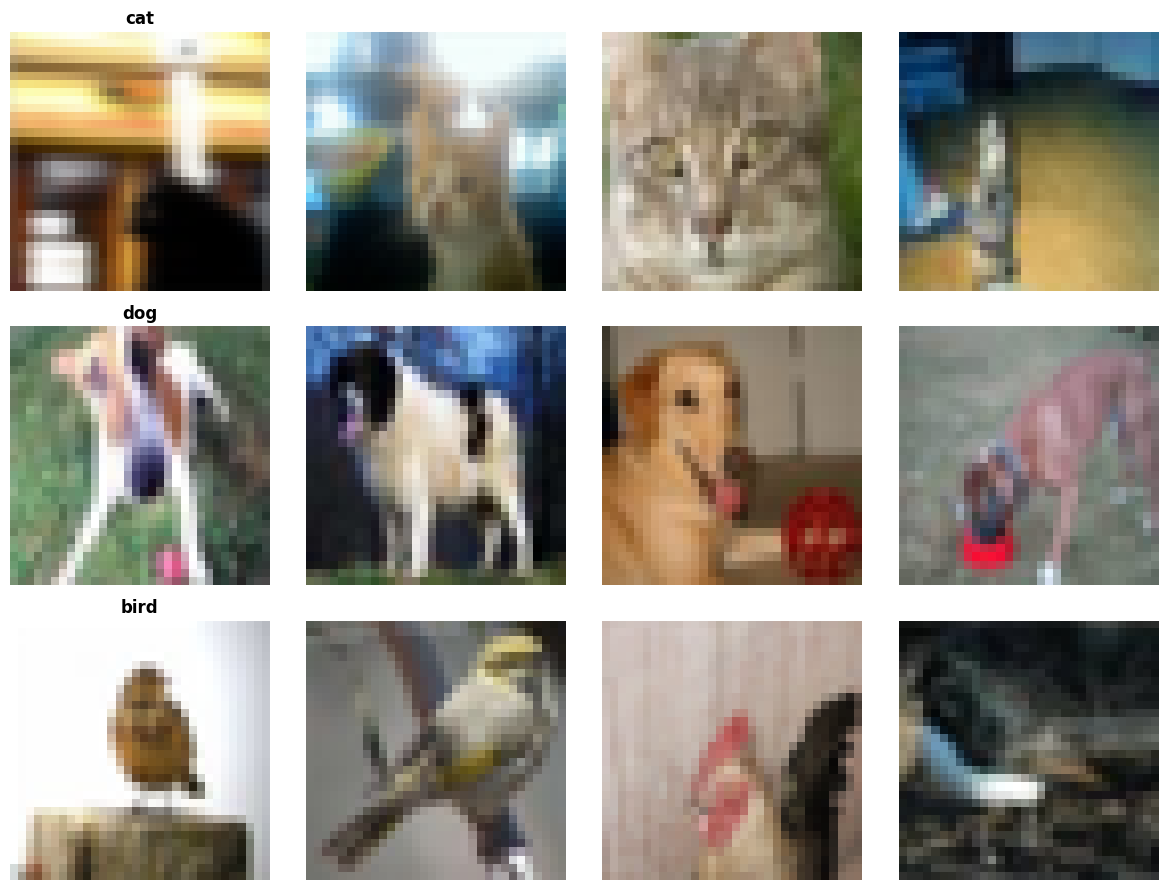

In [ ]:
def visualize_samples_from_classes(image_dir, csv_file, class_names, samples_per_class=4):
    df = pd.read_csv(csv_file)

    fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(samples_per_class * 3, len(class_names) * 3))

    for i, class_name in enumerate(class_names):
        class_images = df[df['label'] == class_name].sample(samples_per_class)

        for j, (_, row) in enumerate(class_images.iterrows()):
            img_path = os.path.join(image_dir, row['filename'])
            image = Image.open(img_path).convert('RGB')

            ax = axes[i, j] if len(class_names) > 1 else axes[j]
            ax.imshow(image)
            ax.axis('off')
            if j == 0:
                ax.set_title(class_name, fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

image_dir = "/content/drive/MyDrive/dataset/train"
csv_file = "/content/drive/MyDrive/dataset/train.csv"
class_names = ['cat', 'dog', 'bird']

visualize_samples_from_classes(image_dir, csv_file, class_names, samples_per_class=4)

# **3.2 Model Development and Training**
## **Simple CNN**

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 3)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

model = CNNModel().to("cuda" if torch.cuda.is_available() else "cpu")

### **Setting Loss Function and Optimizer (Adam)**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### **Model Training Fucntion**

In [ ]:
def train(model, loader):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

### **Model Validation Fucntion**

In [ ]:
def validate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

### **Model Training and Validation Loop**
#### In this loop model is trained on the training dataset and evaluated on the validation dataset at each epoch and then it providing metrics to track performance improvements over time

In [ ]:
for epoch in range(10):
    train_loss = train(model, train_loader)
    val_acc = validate(model, val_loader)
    print(f"Epoch {epoch+1}: Loss: {train_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch 1: Loss: 1.0043, Validation Accuracy: 0.5783
Epoch 2: Loss: 0.8880, Validation Accuracy: 0.6058
Epoch 3: Loss: 0.8370, Validation Accuracy: 0.6229
Epoch 4: Loss: 0.8097, Validation Accuracy: 0.6458
Epoch 5: Loss: 0.7831, Validation Accuracy: 0.6529
Epoch 6: Loss: 0.7688, Validation Accuracy: 0.6571
Epoch 7: Loss: 0.7464, Validation Accuracy: 0.6575
Epoch 8: Loss: 0.7306, Validation Accuracy: 0.6633
Epoch 9: Loss: 0.7071, Validation Accuracy: 0.6754
Epoch 10: Loss: 0.6967, Validation Accuracy: 0.6658


### **Save prediction in CSV for Kaggle submission--> CNN with 10 epochs**

In [ ]:
label_map = {0: 'cat', 1: 'dog', 2: 'bird'}

model.eval()
predictions = []
file_names = []

with torch.no_grad():
    for inputs, filenames in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        predictions.extend([label_map[pred.item()] for pred in preds.cpu()])
        file_names.extend(filenames)

submission = pd.DataFrame({'filename': file_names, 'label': predictions})
submission.to_csv('submission04.csv', index=False)

print("Submission file 'submission04.csv' saved successfully!")

Submission file 'submission04.csv' saved successfully!


### **Training loop but with different epochs**

In [ ]:
for epoch in range(20):
    train_loss = train(model, train_loader)
    val_acc = validate(model, val_loader)
    print(f"Epoch {epoch+1}: Loss: {train_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch 1: Loss: 0.6912, Validation Accuracy: 0.6729
Epoch 2: Loss: 0.6839, Validation Accuracy: 0.6913
Epoch 3: Loss: 0.6614, Validation Accuracy: 0.6742
Epoch 4: Loss: 0.6502, Validation Accuracy: 0.6954
Epoch 5: Loss: 0.6370, Validation Accuracy: 0.6946
Epoch 6: Loss: 0.6202, Validation Accuracy: 0.6983
Epoch 7: Loss: 0.6202, Validation Accuracy: 0.6954
Epoch 8: Loss: 0.6044, Validation Accuracy: 0.7033
Epoch 9: Loss: 0.5873, Validation Accuracy: 0.7063
Epoch 10: Loss: 0.5764, Validation Accuracy: 0.6983
Epoch 11: Loss: 0.5692, Validation Accuracy: 0.7188
Epoch 12: Loss: 0.5563, Validation Accuracy: 0.7167
Epoch 13: Loss: 0.5520, Validation Accuracy: 0.7037
Epoch 14: Loss: 0.5459, Validation Accuracy: 0.7133
Epoch 15: Loss: 0.5278, Validation Accuracy: 0.7142
Epoch 16: Loss: 0.5199, Validation Accuracy: 0.7175
Epoch 17: Loss: 0.5210, Validation Accuracy: 0.7092
Epoch 18: Loss: 0.5106, Validation Accuracy: 0.7229
Epoch 19: Loss: 0.4918, Validation Accuracy: 0.7279
Epoch 20: Loss: 0.496

### **Save prediction in CSV for Kaggle submission --> CNN with 20 epochs**

In [ ]:
label_map = {0: 'cat', 1: 'dog', 2: 'bird'}

model.eval()
predictions = []
file_names = []

with torch.no_grad():
    for inputs, filenames in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        predictions.extend([label_map[pred.item()] for pred in preds.cpu()])
        file_names.extend(filenames)

submission = pd.DataFrame({'filename': file_names, 'label': predictions})
submission.to_csv('submission05.csv', index=False)

print("Submission file 'submission04.csv' saved successfully!")

Submission file 'submission04.csv' saved successfully!


## **Advanced Models**
### **1. ResNet**
### **2. VGG**

In [ ]:
# ResNet-18 Model
resnet_model = models.resnet18(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 3)
resnet_model = resnet_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]


In [ ]:
# VGG-16 Model
vgg_model = models.vgg16(pretrained=True)
vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features, 3)
vgg_model = vgg_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 75.0MB/s]


## **Loss Function, Optimizer, Learning Rate Scheduler for ResNet & VGG**
### **->Regularization (dropout, weight decay)**

In [ ]:
criterion = nn.CrossEntropyLoss()

def get_optimizer_scheduler(model):
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    return optimizer, scheduler

### **Function to train and validate VGG and ResNet**

In [ ]:
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

In [ ]:
def validate(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


In [ ]:
def train_and_validate(model, model_name):
    optimizer, scheduler = get_optimizer_scheduler(model)
    best_acc = 0.0

    for epoch in range(10):
        train_loss = train(model, train_loader, optimizer, criterion)
        val_acc = validate(model, val_loader, criterion)
        scheduler.step()

        print(f"{model_name} Epoch {epoch+1}: Loss: {train_loss:.4f}, Val Accuracy: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"{model_name}_best_model.pth")

### **ResNet Validating for 10 epochs**
## **-> Batch Normalization**

In [ ]:
# Train ResNet-18
train_and_validate(resnet_model, "ResNet18")

ResNet18 Epoch 1: Loss: 0.6682, Val Accuracy: 0.7462
ResNet18 Epoch 2: Loss: 0.4824, Val Accuracy: 0.7662
ResNet18 Epoch 3: Loss: 0.4310, Val Accuracy: 0.7946
ResNet18 Epoch 4: Loss: 0.3929, Val Accuracy: 0.8079
ResNet18 Epoch 5: Loss: 0.3426, Val Accuracy: 0.8004
ResNet18 Epoch 6: Loss: 0.3250, Val Accuracy: 0.7979
ResNet18 Epoch 7: Loss: 0.2859, Val Accuracy: 0.8271
ResNet18 Epoch 8: Loss: 0.1810, Val Accuracy: 0.8708
ResNet18 Epoch 9: Loss: 0.1425, Val Accuracy: 0.8721
ResNet18 Epoch 10: Loss: 0.1224, Val Accuracy: 0.8700


In [ ]:
def generate_predictions(model, model_name):
    model.load_state_dict(torch.load(f"{model_name}_best_model.pth"))
    model.eval()

    label_map = {0: 'cat', 1: 'dog', 2: 'bird'}
    predictions = []
    file_names = []

    with torch.no_grad():
        for inputs, filenames in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            predictions.extend([label_map[pred.item()] for pred in preds.cpu()])
            file_names.extend(filenames)

    submission = pd.DataFrame({'filename': file_names, 'label': predictions})
    submission.to_csv(f'{model_name}_submission.csv', index=False)
    print(f"{model_name} submission file saved successfully!")

## **Generating predicitons for resNet**

In [ ]:
generate_predictions(resnet_model, "ResNet18")

<ipython-input-33-7c6df7b5ea5c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_name}_best_model.pth"))


ResNet18 submission file saved successfully!


In [ ]:
def train_and_validate(model, model_name):
    optimizer, scheduler = get_optimizer_scheduler(model)
    best_acc = 0.0

    for epoch in range(20):
        train_loss = train(model, train_loader, optimizer, criterion)
        val_acc = validate(model, val_loader, criterion)
        scheduler.step()

        print(f"{model_name} Epoch {epoch+1}: Loss: {train_loss:.4f}, Val Accuracy: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"{model_name}_best_model.pth")

## **Again train and validate but with 20 epochs**

In [ ]:
train_and_validate(resnet_model, "ResNet18")

ResNet18 Epoch 1: Loss: 0.2258, Val Accuracy: 0.8163
ResNet18 Epoch 2: Loss: 0.2029, Val Accuracy: 0.8367
ResNet18 Epoch 3: Loss: 0.1861, Val Accuracy: 0.8396
ResNet18 Epoch 4: Loss: 0.1675, Val Accuracy: 0.8346
ResNet18 Epoch 5: Loss: 0.1590, Val Accuracy: 0.8271
ResNet18 Epoch 6: Loss: 0.1585, Val Accuracy: 0.8446
ResNet18 Epoch 7: Loss: 0.1390, Val Accuracy: 0.8225
ResNet18 Epoch 8: Loss: 0.0830, Val Accuracy: 0.8604
ResNet18 Epoch 9: Loss: 0.0516, Val Accuracy: 0.8608
ResNet18 Epoch 10: Loss: 0.0382, Val Accuracy: 0.8608
ResNet18 Epoch 11: Loss: 0.0392, Val Accuracy: 0.8679
ResNet18 Epoch 12: Loss: 0.0325, Val Accuracy: 0.8688
ResNet18 Epoch 13: Loss: 0.0274, Val Accuracy: 0.8608
ResNet18 Epoch 14: Loss: 0.0218, Val Accuracy: 0.8633
ResNet18 Epoch 15: Loss: 0.0179, Val Accuracy: 0.8608
ResNet18 Epoch 16: Loss: 0.0180, Val Accuracy: 0.8642
ResNet18 Epoch 17: Loss: 0.0155, Val Accuracy: 0.8692
ResNet18 Epoch 18: Loss: 0.0129, Val Accuracy: 0.8692
ResNet18 Epoch 19: Loss: 0.0162, Val 

# **ResNet-18 Hyperparameter Tuning**

## --> Enhanced Data Augmentation
## --> Improved Data Transformations

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(10),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

###  **Optimizer,Scheduler and Gradient Clipping**
## **Regularization**

## ->  Optimizer with Weight Decay and Gradient Clipping
## -> Cosine Annealing Scheduler





In [ ]:
optimizer = optim.AdamW(resnet_model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# **Ensemble Models**

### **Gradient in training**

In [ ]:
def train_with_clipping(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

### **MixUp Data Augmentation**

In [ ]:
def mixup_data(x, y, alpha=1.0):
    """Apply MixUp augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
# Update Training Loop for MixUp
def train_with_mixup(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels_a, labels_b, lam = mixup_data(inputs, labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

## **Fine-Tune**

In [ ]:
for param in resnet_model.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(resnet_model.parameters(), lr=1e-4, weight_decay=1e-4)

## **Improved Training and Validation Loop**

In [ ]:
def train_and_validate_improved(model, model_name):
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0

    for epoch in range(20):  # Increased epochs
        if epoch < 10:
            train_loss = train_with_mixup(model, train_loader, optimizer, criterion)
        else:
            train_loss = train_with_clipping(model, train_loader, optimizer, criterion)

        val_acc = validate(model, val_loader, criterion)
        scheduler.step()

        print(f"Epoch {epoch+1}: Loss: {train_loss:.4f}, Val Accuracy: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"{model_name}_best_model_improved.pth")

## **Train resNet with different techniques**

In [ ]:
train_and_validate_improved(resnet_model, "ResNet18") #early stop, no improvment

Epoch 1: Loss: 0.7159, Val Accuracy: 0.8575
Epoch 2: Loss: 0.6174, Val Accuracy: 0.8525
Epoch 3: Loss: 0.5782, Val Accuracy: 0.8642
Epoch 4: Loss: 0.6063, Val Accuracy: 0.8629
Epoch 5: Loss: 0.5701, Val Accuracy: 0.8625
Epoch 6: Loss: 0.5611, Val Accuracy: 0.8700
Epoch 7: Loss: 0.6129, Val Accuracy: 0.8612
Epoch 8: Loss: 0.5932, Val Accuracy: 0.8683
Epoch 9: Loss: 0.5451, Val Accuracy: 0.8642
Epoch 10: Loss: 0.5366, Val Accuracy: 0.8679
Epoch 11: Loss: 0.1121, Val Accuracy: 0.8725
Epoch 12: Loss: 0.0653, Val Accuracy: 0.8662
Epoch 13: Loss: 0.0284, Val Accuracy: 0.8779
Epoch 14: Loss: 0.0146, Val Accuracy: 0.8738
Epoch 15: Loss: 0.0099, Val Accuracy: 0.8712
Epoch 16: Loss: 0.0130, Val Accuracy: 0.8558
Epoch 17: Loss: 0.0218, Val Accuracy: 0.8588
Epoch 18: Loss: 0.0356, Val Accuracy: 0.8454
